In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import json

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from category_encoders import OneHotEncoder, BinaryEncoder
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

n_splits = 10
seed = 42
np.random.seed(seed)

k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

#### 1 Read and describe data

In [72]:
matches_df = pd.read_csv("../../../data_for_training/MU_clustered.csv")
matches_df.columns

Index(['result', 'venue', 'season', 'win_percent_diff',
       'draw_percent_before_team2', 'draw_percent_diff',
       'lose_percent_before_team1', 'lose_percent_before_team2',
       'head2head_win_percent', 'head2head_draw_percent',
       'head2head_lost_percent', 'is_opponent_big6', 'ELO_before_match_team2',
       'ELO_before_diff', 'average_score_before_match_team2',
       'average_score_before_match_diff', 'Cluster', 'match_type'],
      dtype='object')

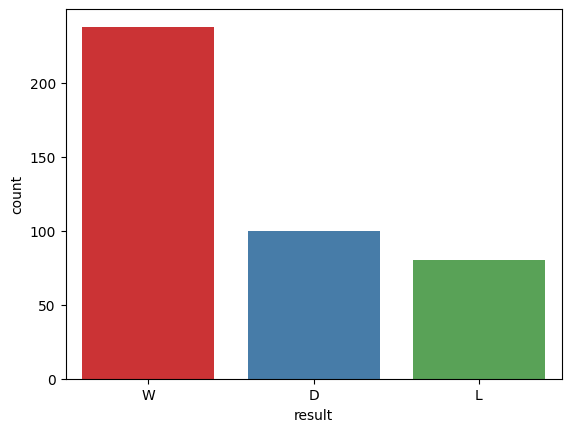

In [73]:
matches_df = matches_df.drop(
    columns=[
        "average_score_before_match_diff",
    ]
)

sns.countplot(x="result", data=matches_df, palette="Set1");

### Phân chia dữ liệu thành X, y

In [74]:
X = matches_df.drop("result", axis=1)
X.head()

,venue,season,win_percent_diff,draw_percent_before_team2,draw_percent_diff,lose_percent_before_team1,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type
0,Home,2010-2011,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,1500.000000,0.000000,0.000000,1,Weak Opponent
1,Away,2010-2011,1.000000,1.000000,-1.0,0.0,0.000000,0.0,0.0,0.0,0,1500.000000,43.750000,1.000000,2,Strong Opponent
2,Home,2010-2011,0.500000,0.000000,0.5,0.0,1.000000,0.0,0.0,0.0,0,1423.447297,123.434234,0.000000,1,Weak Opponent
3,Away,2010-2011,0.666667,0.333333,0.0,0.0,0.666667,0.0,0.0,0.0,0,1439.210463,136.500439,0.333333,2,Strong Opponent
4,Home,2010-2011,0.250000,0.500000,0.0,0.0,0.250000,0.0,0.0,0.0,1,1486.769988,98.286921,1.250000,0,Average Opponent


In [75]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(matches_df["result"])

In [76]:
# Xác định các cột phân loại và cột số
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop('Cluster')

numerical_cols, categorical_cols

(Index(['win_percent_diff', 'draw_percent_before_team2', 'draw_percent_diff',
        'lose_percent_before_team1', 'lose_percent_before_team2',
        'head2head_win_percent', 'head2head_draw_percent',
        'head2head_lost_percent', 'is_opponent_big6', 'ELO_before_match_team2',
        'ELO_before_diff', 'average_score_before_match_team2'],
       dtype='object'),
 Index(['venue', 'season', 'match_type'], dtype='object'))

#### Encoding cho các đặc trưng

In [77]:
X_no_cluster = X.drop(['Cluster', 'match_type'], axis=1)

In [78]:
preprocessor = ColumnTransformer(
    transformers=[
        ("venue", OneHotEncoder(use_cat_names=True), ["venue"]),
        ("season", BinaryEncoder(), ["season"]),
        ('num', StandardScaler(), numerical_cols),
    ]
)

transformed_X = preprocessor.fit_transform(X_no_cluster)

# Hiển thị dữ liệu sau khi tiền xử lý
columns = (
    list(preprocessor.named_transformers_["venue"].get_feature_names_out())
    + list(preprocessor.named_transformers_["season"].get_feature_names_out())
    + numerical_cols.tolist()
)

transformed_X = pd.DataFrame(transformed_X, columns=columns)
transformed_X.head()

,venue_Home,venue_Away,season_0,season_1,season_2,season_3,win_percent_diff,draw_percent_before_team2,draw_percent_diff,lose_percent_before_team1,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,1.0,0.0,0.0,0.0,0.0,1.0,-0.592871,-1.202705,0.107827,-0.970572,-1.404527,-1.971208,-1.049189,-0.868172,-0.597614,0.017863,-0.795276,-1.853811
1,0.0,1.0,0.0,0.0,0.0,1.0,2.358538,3.615801,-3.390626,-0.970572,-1.404527,-1.971208,-1.049189,-0.868172,-0.597614,0.017863,-0.660835,-0.488561
2,1.0,0.0,0.0,0.0,0.0,1.0,0.882834,-1.202705,1.857053,-0.970572,2.555624,-1.971208,-1.049189,-0.868172,-0.597614,-0.285074,-0.415970,-1.853811
3,0.0,1.0,0.0,0.0,0.0,1.0,1.374735,0.403463,0.107827,-0.970572,1.235574,-1.971208,-1.049189,-0.868172,-0.597614,-0.222695,-0.375818,-1.398728
4,1.0,0.0,0.0,0.0,0.0,1.0,0.144981,1.206548,0.107827,-0.970572,-0.414490,-1.971208,-1.049189,-0.868172,1.673320,-0.034491,-0.493246,-0.147249


In [79]:
X_cluster = X[['Cluster', 'match_type']]

In [80]:
match_type_order = ['Weak Opponent', 'Average Opponent', 'Strong Opponent']

preprocessor_for_clustering = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["Cluster"]),
        ("match_type", OrdinalEncoder(categories=[match_type_order]), ["match_type"]),
    ]
)

# Sử dụng dữ liệu X_cluster, biến này cần được định nghĩa trước
transformed_X_for_clustering = preprocessor_for_clustering.fit_transform(X_cluster)

In [81]:
# Hiển thị dữ liệu sau khi tiền xử lý
columns_for_clustering = (
    ["Cluster"]
    + list(preprocessor_for_clustering.named_transformers_["match_type"].get_feature_names_out())
)


transformed_X_clustering_df = pd.DataFrame(transformed_X_for_clustering, columns=columns_for_clustering)
transformed_X_clustering_df.head()

,Cluster,match_type
0,-0.033194,0.0
1,1.228196,2.0
2,-0.033194,0.0
3,1.228196,2.0
4,-1.294585,1.0


In [82]:
transformed_X = pd.concat([transformed_X, transformed_X_clustering_df], axis=1)
transformed_X

,venue_Home,venue_Away,season_0,season_1,season_2,season_3,win_percent_diff,draw_percent_before_team2,draw_percent_diff,lose_percent_before_team1,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type
0,1.0,0.0,0.0,0.0,0.0,1.0,-0.592871,-1.202705,0.107827,-0.970572,-1.404527,-1.971208,-1.049189,-0.868172,-0.597614,0.017863,-0.795276,-1.853811,-0.033194,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,2.358538,3.615801,-3.390626,-0.970572,-1.404527,-1.971208,-1.049189,-0.868172,-0.597614,0.017863,-0.660835,-0.488561,1.228196,2.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.882834,-1.202705,1.857053,-0.970572,2.555624,-1.971208,-1.049189,-0.868172,-0.597614,-0.285074,-0.415970,-1.853811,-0.033194,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.374735,0.403463,0.107827,-0.970572,1.235574,-1.971208,-1.049189,-0.868172,-0.597614,-0.222695,-0.375818,-1.398728,1.228196,2.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.144981,1.206548,0.107827,-0.970572,-0.414490,-1.971208,-1.049189,-0.868172,1.673320,-0.034491,-0.493246,-0.147249,-1.294585,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.0,1.0,1.0,0.0,1.0,1.0,0.587693,-0.239004,0.107827,-0.970572,0.179533,0.894322,-0.050356,-0.868172,-0.597614,0.423250,0.196544,0.057539,1.228196,2.0
414,1.0,0.0,1.0,0.0,1.0,1.0,0.587693,-0.239004,0.107827,-0.970572,0.179533,0.894322,-0.050356,-0.868172,-0.597614,1.059588,-0.098226,0.057539,-0.033194,0.0
415,1.0,0.0,1.0,0.0,1.0,1.0,-0.592871,0.724697,-0.591863,0.080916,-1.404527,0.894322,-0.050356,-0.868172,1.673320,1.138882,-0.310913,1.149739,-1.294585,1.0
416,1.0,0.0,1.0,0.0,1.0,1.0,0.587693,-0.239004,0.107827,1.132403,1.763594,1.252513,-0.549773,-0.868172,-0.597614,-1.951682,1.924827,-1.580761,1.228196,2.0


In [83]:
X = transformed_X

In [84]:
from imblearn.over_sampling import SMOTENC

smote = SMOTENC(categorical_features=[0, 1, 2, 3, 4, 5, 6], random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Huấn luyện mô hình với dữ liệu đã xử lý mất cân bằng
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.61      0.75      0.67        57
           1       0.69      0.78      0.73        65
           2       0.73      0.55      0.63        93

    accuracy                           0.67       215
   macro avg       0.67      0.70      0.68       215
weighted avg       0.68      0.67      0.67       215



Counter({2: 238, 0: 238, 1: 238})


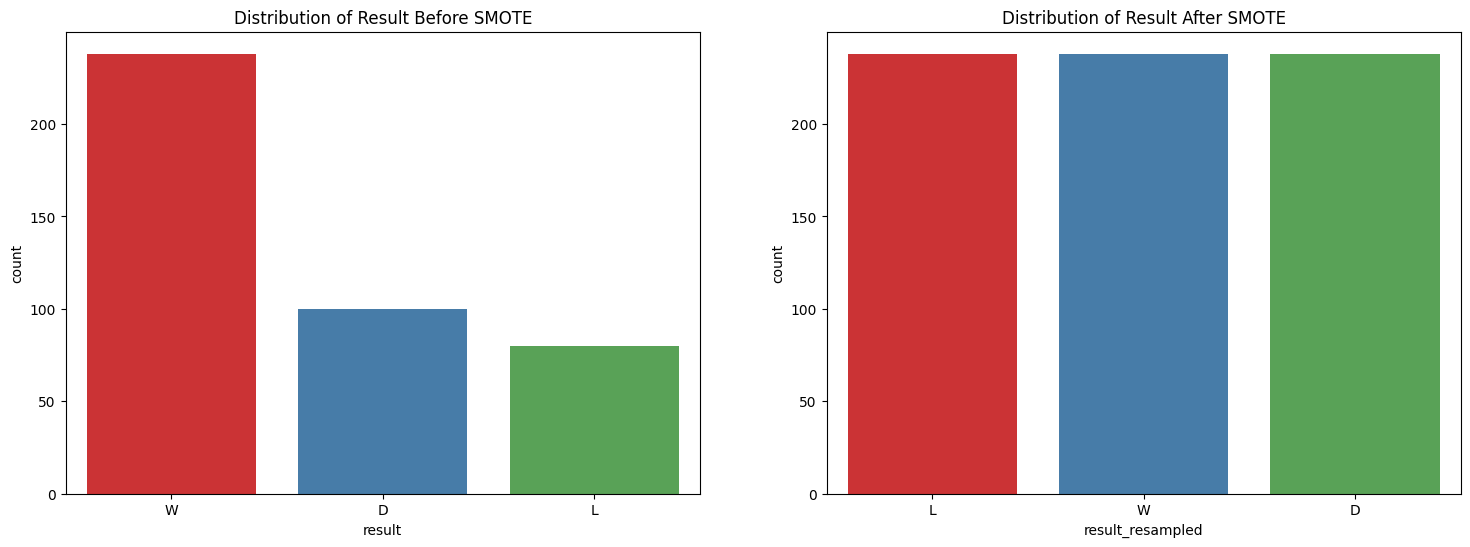

In [85]:
from collections import Counter

# Xem số lượng các giá trị trong y_resampled
counter = Counter(y_resampled)
print(counter)

# Vẽ biểu đồ phân phối của nhãn trước và sau khi áp dụng SMOTE trên cùng một figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Trước khi áp dụng SMOTE
sns.countplot(x="result", data=matches_df, palette="Set1", ax=axes[0])
axes[0].set_title('Distribution of Result Before SMOTE')

# Sau khi áp dụng SMOTE
resampled_df = pd.DataFrame(y_resampled, columns=["result_resampled"])
sns.countplot(x="result_resampled", data=resampled_df, palette="Set1", ax=axes[1])
axes[1].set_title('Distribution of Result After SMOTE')
axes[1].set_xticklabels(['L', 'W', 'D'])

plt.show()

In [86]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)

# print(f'Best parameters found: {grid_search.best_params_}')
# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(X_test)
# print(classification_report(y_test, y_pred))


In [87]:
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Thử nghiệm với SVM
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print('SVM Classification Report:')
print(classification_report(y_test, y_pred_svc))

# Thử nghiệm với XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        57
           1       0.62      0.71      0.66        65
           2       0.72      0.52      0.60        93

    accuracy                           0.62       215
   macro avg       0.63      0.64      0.62       215
weighted avg       0.64      0.62      0.62       215

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        57
           1       0.75      0.78      0.77        65
           2       0.77      0.67      0.71        93

    accuracy                           0.72       215
   macro avg       0.71      0.72      0.72       215
weighted avg       0.72      0.72      0.72       215



In [88]:
from sklearn.model_selection import cross_val_score

# Đánh giá mô hình với cross-validation
cv_scores = cross_val_score(rf, transformed_X, y, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {cv_scores.mean()}')


Cross-validation scores: [0.54761905 0.52380952 0.53571429 0.53012048 0.51807229]
Average cross-validation score: 0.5310671256454389


### Thử nghiệm các mô hình

In [89]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed, class_weight="balanced")),
    (
        "SVC",
        SVC(
            probability=True,
            random_state=seed,
            class_weight="balanced",
        ),
    ),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed, class_weight="balanced")),
    (
        "SGDC",
        CalibratedClassifierCV(
            SGDClassifier(random_state=seed, class_weight="balanced")
        ),
    ),
    ("NB", GaussianNB()),
    (
        "RF",
        RandomForestClassifier(
            n_estimators=100, random_state=seed, class_weight="balanced"
        ),
    ),
]

cv_results = {}

for name, model in algorithms:
    # Thực hiện cross-validation
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=k_fold, scoring="accuracy")
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"Accuracy {name}: {score}")

Accuracy LR: 0.4957550860719874
Accuracy SVC: 0.651095461658842
Accuracy KNN: 0.6905516431924882
Accuracy DTC: 0.6358959311424102
Accuracy SGDC: 0.4637715179968701
Accuracy NB: 0.5346830985915493
Accuracy RF: 0.7296948356807512


### Chọn bộ siêu tham số

#### RF

In [90]:
# best_params_RF = {}
# models_tuned_RF = {}

# # Adjust your algorithms list to use descriptive names that match param_grid
# algorithms = [
#     ('RF', RandomForestClassifier()),
# ]

# # Define parameter grid with correct keys
# param_grid = {
#     "RF": {
#         "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
#         "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6],
#         "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
#         "min_samples_split": [2, 5, 10, 20],
#         "min_samples_leaf": [1, 2, 4, 6],
#         "class_weight": ["balanced"]
#     }
# }


# # Randomized Search application with check for parameter grid existence
# for name, model in algorithms:
#     print("Model processing: ", name)
#     if name in param_grid:
#         randomized_search = RandomizedSearchCV(
#             estimator=model, 
#             param_distributions=param_grid[name], 
#             n_iter=100,
#             cv=k_fold, 
#             scoring='accuracy', 
#             random_state=42,
#             n_jobs=-1,
#             verbose=1
#         )
#         randomized_search.fit(X, y)
#         best_params_RF[name] = randomized_search.best_params_
#         models_tuned_RF[name] = randomized_search.best_estimator_
#     else:
#         print(f"No parameter grid defined for {name}")


## Thử nghiệm bộ tham số

#### Random forest

In [91]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(
        model, X_resampled, y_resampled, cv=k_fold, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"{name}: {score}")

RF: 0.743701095461659


## Test Vẽ ma trận nhầm lẫn của model có độ chính xác cao nhất

In [92]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed, stratify=y_resampled)

In [93]:
from sklearn.metrics import confusion_matrix

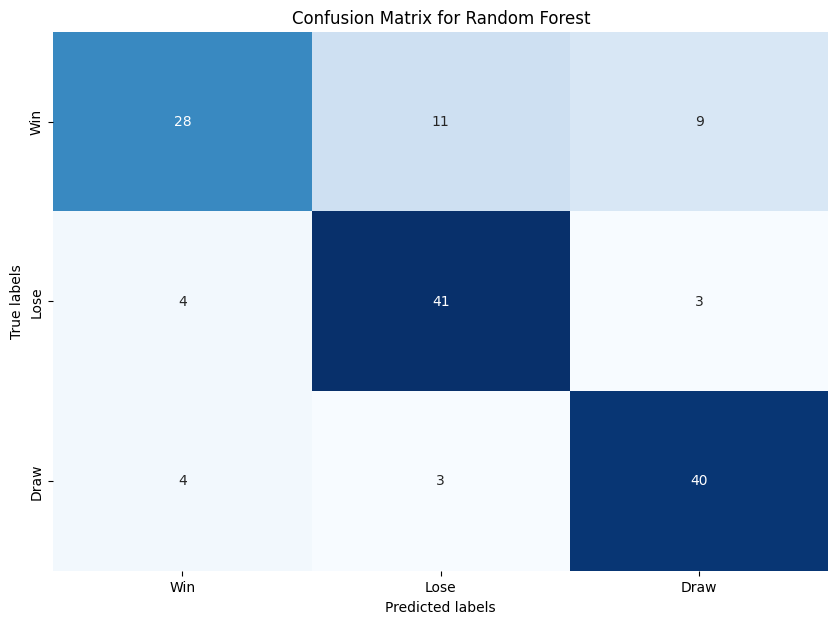

In [94]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)
    best_params_RF["RF"].pop("class_weight", None)

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)

y_pred = rf_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]

cm_reordered = cm[desired_indices, :][:, desired_indices]
df_cm = pd.DataFrame(cm_reordered, index=desired_labels, columns=desired_labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [95]:
import pickle
def save_model(model, file_name):
    with open(file_name, "wb") as file:
        pickle.dump(model, file)

In [96]:
# Lưu các encoder
save_model(preprocessor, "final_model_clustered/preprocessor.pkl")

In [97]:
# Lưu các encoder
save_model(preprocessor_for_clustering, "final_model_clustered/preprocessor_clustering.pkl")

In [98]:
# Lưu model vào file joblib
import joblib

with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)
    best_params_RF["RF"]["class_weight"] = "balanced"

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)
rf_model.fit(X, y)

save_model(rf_model, "final_model_clustered/RF.pkl")

### Tạo model cho việc phân cụm

In [99]:
X_resampled.columns

Index(['venue_Home', 'venue_Away', 'season_0', 'season_1', 'season_2',
       'season_3', 'win_percent_diff', 'draw_percent_before_team2',
       'draw_percent_diff', 'lose_percent_before_team1',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2', 'Cluster', 'match_type'],
      dtype='object')

In [100]:
from sklearn.cluster import KMeans
import pickle

# Loại bỏ các cột không phù hợp khỏi tập dữ liệu huấn luyện
X_train = X_resampled.drop(['match_type', 'Cluster'], axis=1)

# Huấn luyện mô hình KMeans mới
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train)

# Lưu mô hình phân cụm mới
with open("final_model_clustered/kmeans_model.pkl", "wb") as file:
    pickle.dump(kmeans, file)


In [101]:
preprocessor.feature_names_in_

array(['venue', 'season', 'win_percent_diff', 'draw_percent_before_team2',
       'draw_percent_diff', 'lose_percent_before_team1',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent',
       'is_opponent_big6', 'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2'], dtype=object)

In [102]:
preprocessor_for_clustering.feature_names_in_

array(['Cluster', 'match_type'], dtype=object)